## Divy dataset example: HyperLogLog intersection support and dask computation

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import dask.dataframe as dd
import dask

In [4]:
from dask.distributed import Client, progress
client = Client()  # start distributed scheduler locally.  Launch dashboard on 8786

In [5]:
import matplotlib.pyplot as plt

In [6]:
import hyperloglog
from hyperloglog import HyperLogLog

In [7]:
# download dataset from kaggle.com
ddf = dd.read_csv('/home/scott/bigbothd/divvy/data.csv',
                  dtype=object, 
                  blocksize='128MiB')

In [8]:
%time ddf.head()

CPU times: user 80 ms, sys: 5.21 ms, total: 85.2 ms
Wall time: 2.25 s


,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10.066666666666666,68.0,tstorms,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.64598000000001,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4.383333333333334,68.0,tstorms,282,Halsted St & Maxwell St,41.86458,-87.64693,15.0,22,May St & Taylor St,41.8694821,-87.6554864,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2.1,68.0,tstorms,327,Sheffield Ave & Webster Ave,41.921687,-87.65371400000001,19.0,225,Halsted St & Dickens Ave,41.919936,-87.64883,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58.016666666666666,68.0,tstorms,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.62775,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10.633333333333333,68.0,tstorms,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [9]:
%time ddf.trip_id.shape[0].compute()

CPU times: user 399 ms, sys: 71.5 ms, total: 471 ms
Wall time: 10 s


9495235

In [10]:
%time ddf.trip_id.nunique().compute()

CPU times: user 758 ms, sys: 101 ms, total: 859 ms
Wall time: 20.4 s


9495188

In [11]:
%time ddf.trip_id.nunique_approx().compute()

CPU times: user 469 ms, sys: 94.2 ms, total: 563 ms
Wall time: 12 s


9584730.548938287

### Parallel unique counting with hyperloglog

In [8]:
# def hll_count(df_sub):
#     hll = hyperloglog.HyperLogLog(0.01)  # accept 1% counting error
#     df_sub['trip_id'].map( hll.add );
#     return hll

In [8]:
def hll_count_series(series):
    hll = hyperloglog.HyperLogLog(0.01)  # accept 1% counting error
    series.map( hll.add );
    return hll

In [9]:
res = ddf['trip_id'].map_partitions(hll_count_series, meta=('this_result','f8'))

In [10]:
res = res.to_delayed()

In [11]:
len(res)

16

In [12]:
def hll_reduce(x, y):
    x.update(y)
    return x

#### Tree reduction approach

In [13]:
L = res
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = dask.delayed(hll_reduce)(L[i-1], L[i])  # add neighbors  
        new_L.append(lazy)
    L = new_L                       # swap old list for new

In [14]:
%time len( dask.compute( *L )[0] )

CPU times: user 774 ms, sys: 53.9 ms, total: 828 ms
Wall time: 19.9 s


9570193

In [16]:
hll_res = dask.compute( *L )[0]

In [17]:
hll_res_0 = dask.compute( res[0] )[0].serialize()
hll_res_1 = dask.compute( res[1] )[0].serialize()

In [ ]:
hll_res_sr = hll_res.serialize_registers()

In [23]:
hll_res_1

b'x\x9c=\x9b\xed\x92\xec6\xael#n\xf1[\xaan{\xfe\x9c\xf7\x7f\xd3\x8b\xb5\x92\xed\x18\x8f\xb7wUI"A \x91H@s\xcc\xbe\xfa\\g\xf4v\x9eO\x9f\xcf\x18\xa7\xcf>\xfahs\xec\xd1\xdf6f}7\xc7g\xd4O{\xdfcu\xfe\xa9\xef\xd7\xe8s\x8f9\xeb\xcb6\x06\xd7\xad\xf3\xb3\xf8\xb8\xaf\xf5<\xf3\xa9/z\xfdm\xcfY\x8f\x18k\xfd\xec\xba\xf1S\x9f\xd4\xcf\xb9\xa6\xd5\x8f\xf9s\xcdV\xd7\x8c\xfa\x7f\xfdYO\xd9\xedS\x1fr\xcb\xc1\x1a\xea&\xbd\x9fQ\x9f\xd4}\xfal\xf5\xf4VK\xae+\xcf\xac/\xe7S\xebe-<\xa3\xbe\x1e\xb3\xb9\xf8z\xf8\xf0\xb6\xdc\xa9mV\xb9xB\xfd\xa6~1\xe7x\xbc\xa4\xd5\xa6V\x9b\xdc\xafn:\xb8\xc7f?\xbbn\xce\xba\xd7\xaa\x9f\xb7\xb2@c\xa7e\'\x16\xb4\xeb\xc3\xb5\xb0\xddX\x8d\x05\xd6\x13\xc6S\xb7e#\xbb\xee8\xe6~\'\xa6m\xb5\xbc\xbaE\x9b\xb5\x03V;\xca\x1ae\xc7z\xd2[\xbb\x9b\xf5\x90\xfdm\rK?\xb3\xbe\xe2\x06lr\x97\xe1y\x16vXl\xa3,^\x17\x96\xa9\xea&\x87-\xacV\xf7\xe4\x10xd-\x86\x15q}=\xa7\xb3\x1e\xce\xf0\xc4\x84\\\xa2-<\x08\xd6Zk~X\xdd\xaaG\xb6\xfd.\x97V?\x99\x9b\xbb\x95\x95\xbcr<e\xc7z~\x99\xa6\xd6v\xb8?w}|d\xddC\xbbk\xb1\xba\xae\x

In [41]:
sorted( set( [*[4], *[ *[1,2,9], *[3,6,0,3,4,5,3] ]] ))

[0, 1, 2, 3, 4, 5, 6, 9]

In [17]:
ks = [ [1,2,3], [5,6,0] ]

In [18]:
dicts = [ {'k':[1,2,3]},{'k':[5,6,0]} ]

In [24]:
[ i for item in dicts for i in item['k'] ]

[1, 2, 3, 5, 6, 0]

In [20]:
sorted([] + [4])[:4]

[4]

In [18]:
hll_empty = HyperLogLog(0.01)

In [19]:
hll_empty.__setstate__( HyperLogLog.deserialize(hll_res_0) )

In [20]:
hll_empty.k

SortedSet([68212472561497, 73925000420021, 80522207739778, 85522977043211, 86931337448449, 100429775376016, 209275222981081, 209379320728435, 269542651808245, 272191633065337, 273602444985899, 296956572541259, 320124233505549, 368751768956057, 383900932772255, 404232668642753, 432906042983141, 551784116153187, 585241044815507, 589622698271821, 593802653265191, 617625761528477, 702708316240812, 750265297240288, 818220131557604, 829964708291522, 860064423935864, 870167925519729, 885412800698917, 908434678568519, 928454994305924, 1050736401766774, 1065371659463202, 1086720445680158, 1100053267012015, 1157707423763917, 1201159702845172, 1231008551396390, 1240131974531118, 1266897712410056, 1334197784392432, 1346203853569871, 1398938594564253, 1430840485705120, 1441156722727881, 1464889496914871, 1531284424654477, 1569553701087434, 1620009991909992, 1677239591388295, 1749036952987414, 1758714626557807, 1760892470853875, 1775701640961297, 1837111425748408, 1842236262964190, 1852644346844128,

In [21]:
hll_empty_1 = HyperLogLog(0.01)
hll_empty_1.__setstate__( HyperLogLog.deserialize(hll_res_1) )

In [24]:
HyperLogLog.get_intersection_card( [hll_empty,hll_empty_1] )

616903

In [26]:
def jaccard(ks):
    ks = [set(i) for i in ks]
    return len( set.intersection(*ks) ) / len( set.union(*ks) )

In [23]:
hll_empty.update(hll_empty_1)

In [93]:
hll_empty_1.update(hll_empty)

In [39]:
from random import sample
sample([1,2,3,4,5],3)

[4, 5, 1]

In [27]:
jaccard( [ hll_empty.k, hll_empty_1.k[:1024] ] )

0.5

In [30]:
def get_max_card(x):
    return max([ hll.card() for hll in x])

In [31]:
max_card = get_max_card( [hll_empty, hll_empty_1] )

In [32]:
max_card

1206728.4372859586

In [33]:
def get_corrected_ks(x):
    max_card = get_max_card( x )
    return [ hll.k[:int(2048*hll.card()/max_card)] for hll in x  ]

In [34]:
corrected_ks = get_corrected_ks( [hll_empty, hll_empty_1] )

In [35]:
jaccard( corrected_ks )

0.511219512195122

In [36]:
def get_corrected_jaccard(x):
    return jaccard( get_corrected_ks(x) )

In [94]:
get_corrected_jaccard( [hll_empty, hll_empty_1] )

0.4837929366231253

In [37]:
def get_intersection_card(x):
    hll_temp = HyperLogLog(0.01)
    [hll_temp.update(hll) for hll in x]
    return int( get_corrected_jaccard( x ) * hll_temp.card() )

In [38]:
get_intersection_card( [hll_empty, hll_empty_1] )

616903

In [97]:
hll_empty.card()

600578.8455301118

In [98]:
hll_empty_1.card()

1206728.4372859586

In [21]:
hll_empty.setstate_from_serialized( hll_res_sr, return_len=True )

9570193

In [27]:
hll_empty_1 = HyperLogLog(0.01)

In [28]:
hll_empty_1.setstate_from_serialized( hll_res_0, return_len=True )

600579

In [29]:
hll_empty_2 = HyperLogLog(0.01)

In [30]:
hll_empty_2.setstate_from_serialized( hll_res_1, return_len=True )

619104

In [26]:
hll_empty.update( *[hll_empty_1, hll_empty_2] )

In [27]:
hll_empty.card()

9570192.670578469

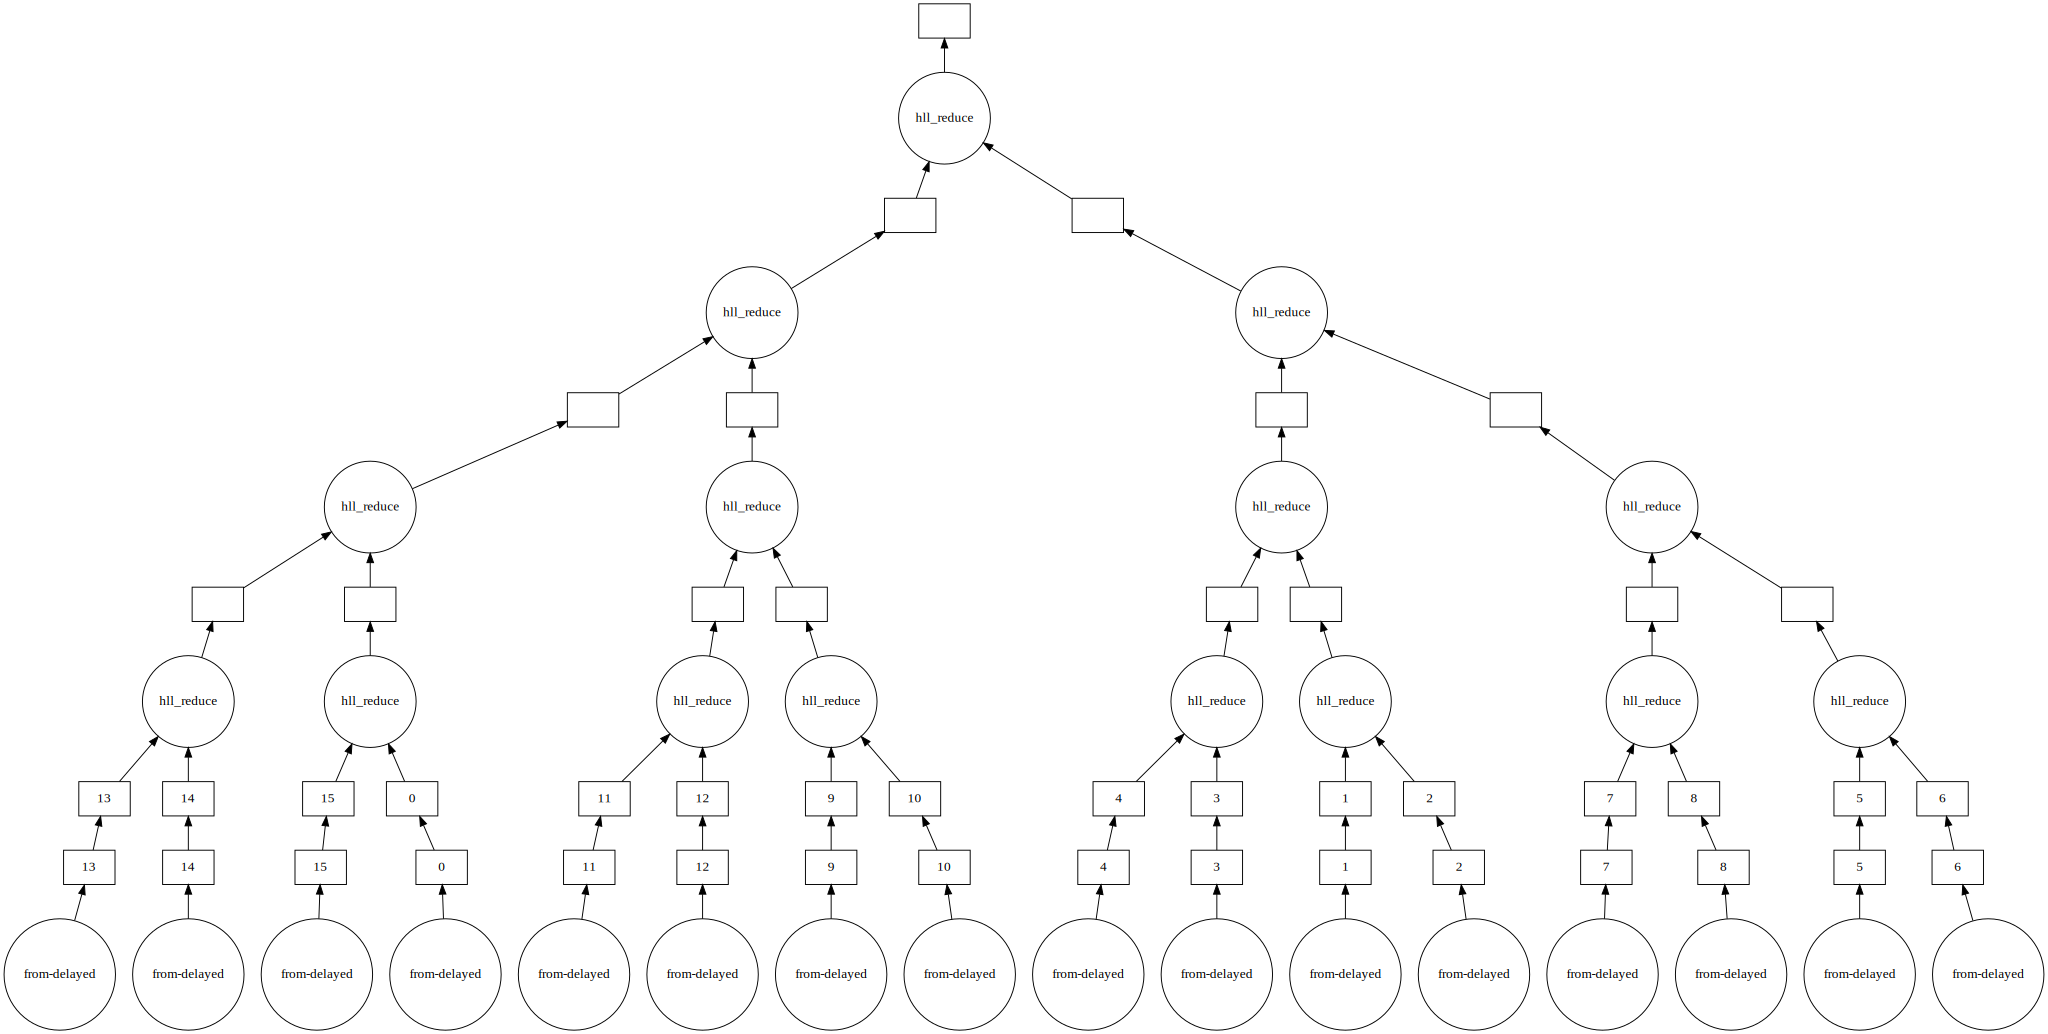

In [43]:
dask.visualize( *L, format='svg', filename='tree-reduce-graph' )

#### making a function

In [45]:
def get_tasks( res ):
    L = res.to_delayed()
    while len(L) > 1: # tree reduction
        new_L = []
        for i in range(0, len(L), 2):
            lazy = dask.delayed( hll_reduce )(L[i-1], L[i])  # add neighbors  
            new_L.append( lazy )
        L = new_L                       # swap old list for new
    return L

In [46]:
def hll_serialize(x):
    return x.serialize()

In [47]:
def get_serialized_hll( series ):
    '''returns serialized hll from dask series as dask delayed object'''
    res = series.map_partitions( hll_count_series , meta=('this_result','f8'))
    L = get_tasks(res)
    S = dask.delayed( hll_serialize )(L[0])
    #return dask.compute( *L )[0].serialize_registers()
    return S

In [48]:
%time hll_serial = get_serialized_hll( ddf['trip_id'] )#.compute()

CPU times: user 26.4 ms, sys: 0 ns, total: 26.4 ms
Wall time: 22.2 ms


In [49]:
%time len ( hll_serial.compute() )

CPU times: user 672 ms, sys: 103 ms, total: 775 ms
Wall time: 19.4 s


554279

#### custom groupbys

In [20]:
def groupby_approx_counts( ddf, x, countby='trip_id' ):
    '''
    input: takes in dask dataframe and item to group by, as well as item to count by
    output: tuple containing: list of unique values in the item to group by, a list of dask delayed objects with the serialized hll object
    '''
    results = []
    uniques = ddf[x].unique().compute().tolist()
    for value in uniques:
        results.append( get_serialized_hll( ddf[ ddf[x]==value ][countby] ) )
        
    serial_objs = dask.compute( *results )
    
    return x, uniques, serial_objs


    the knowledge_dict with hll creates "a data structure to store and explore"

In [22]:
knowledge_dict = {}

In [27]:
knowledge_dict[field] = {}

In [21]:
%time field, values, serial_objs = groupby_approx_counts( ddf, 'gender', countby='trip_id' )

CPU times: user 1.48 s, sys: 225 ms, total: 1.71 s
Wall time: 42.4 s


In [ ]:
knowledge_dict[field] = {}

In [26]:
%time field, values, serial_objs = groupby_approx_counts( ddf, 'month', countby='trip_id' )

CPU times: user 5.67 s, sys: 749 ms, total: 6.42 s
Wall time: 2min 23s


In [28]:
for i, val in enumerate( values ):
    knowledge_dict[field][val] = serial_objs[i]

In [29]:
knowledge_dict.keys()

dict_keys(['gender', 'month'])

In [32]:
knowledge_dict['month']['6']

b'x\x9cd\x9d\x05X\x14\xdf\xd7\xc7\xa9\xdd\xd9\x04,\x14\x11\x1bD\xec\xc0DQ\xb1\xc7n\xecD\x10\xfd)&\x06\x06\x8a v\xa1\x88\x85\xdd\x8a-J\xd8\x8d`\x8b\x89\xdd\xdd\xf9~wg\xce\x9c\xe1\xff><\xea\xc7\xdd\x89\x1b\xa7\xef\x9da\xb2}x\xa8\x8dW\x17\x8d\x8d\x8dM\x9f\xc1\xc3\x82\xfa\x84\xda6\xf1{\x96wr\x91#\x17\x87w\xb1\xc5\x87\xc3B\xedDG+\r\t\xb5oiS\xcf\x8a-C\x1dz\x84j\xbcD\xad(\xe0\xc7\x84\x7f-d\xc4\x1f\x0b\x19\xac\xff\xeaE\x9d\xa8\xb1\xfeO\x8b\x7fuV\xd2\xe1\xc7`=F/\x1fo\xf9\xd1\xe1\x8f\xde\xfac\xf9\xd6`=Kg=J\xa7\x1c\xa1\xb7^Uo\xfd\xa3\xc1\x8f\x11?\x0e\xd6\xbb\xea\xacw3\xcbGjTgk\xe4\xfb\xe9\xe5\xf3\xb4\xf21Z\xb9}\x16v\xc0Qz\xb9ez\xeb9Zk\xbb\x0cr_\xb4\xf2\xf1:\xf9zz\xa5E\xd2w\x1a\xf98A\xee\xa1\x11\xff:\xc8\xa4Q\xfaFw7\xc8\x9fX\xce3Y\xd9(\x7f\xa3\xb5\xf6\x8b\xee&\xdd\xc1 \x9f\xa7WZE\xe3j!\xb3<>\xd4r\xad\xb5\xef&\xeb\xfft\xd6s\xa4~Im3Y\xc7U\xb0\xfe\xad\x91\xafa\x14\x9d\xe4\x991Y\xbf\x93Z\xe4d\xbd\x92^\x9eGK\xdb\x1d\xad\xf7\xd0\xc9\xf7\x95\xc6@c\xfd\xa3\xb7\x9e\xad\xee\x9f4&f\xf9\xbe\x969rPF\x9c\xc6\xd

In [30]:
hll_test = HyperLogLog(0.01)

In [31]:
hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender']['Female']) )

In [53]:
hll_test_2 = HyperLogLog(0.01)
hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month']['7']) )

In [54]:
HyperLogLog.get_intersection_card( [hll_test, hll_test_2] )

360552

In [59]:
def get_min_card(x):
    return min( [ hll.card() for hll in x ] )

def containment(x):
    int_card = HyperLogLog.get_intersection_card(x)
    return [int_card / len(i) for i in x]

In [60]:
containment([hll_test, hll_test_2])

[0.15116641294217137, 0.2791739192378451]

In [61]:
HyperLogLog.get_corrected_jaccard([hll_test, hll_test_2])

0.10865771885734353

In [ ]:
# hll_test2 = HyperLogLog(0.01)
# hll_test2.setstate_from_serialized_list( [ knowledge_dict['month']['1']], 
#                                                   #knowledge_dict['month']['1'] ], 
#                                                 operation='or',
#                                                 return_len=True  )

In [38]:
data_list = []

for month in knowledge_dict['month']:
    for gender in knowledge_dict['gender']:
        hll_test = HyperLogLog(0.01)
        hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender'][gender]) )
        hll_test_2 = HyperLogLog(0.01)
        hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month'][month]) )
        card_int = HyperLogLog.get_intersection_card( [hll_test, hll_test_2] )
        data_list.append( [month, gender, card_int] )

In [39]:
df_inter = pd.DataFrame( data_list, columns=['month','gender','card estimate'] )
df_inter['month'] = df_inter['month'].astype(int)
df_inter = df_inter.sort_values(['month','gender']).reset_index(drop=True)
print( df_inter.to_markdown(tablefmt="github") )

|    |   month | gender   |   card estimate |
|----|---------|----------|-----------------|
|  0 |       1 | Female   |           51188 |
|  1 |       1 | Male     |          222455 |
|  2 |       2 | Female   |           59210 |
|  3 |       2 | Male     |          246677 |
|  4 |       3 | Female   |           93464 |
|  5 |       3 | Male     |          340408 |
|  6 |       4 | Female   |          141403 |
|  7 |       4 | Male     |          476394 |
|  8 |       5 | Female   |          212724 |
|  9 |       5 | Male     |          668272 |
| 10 |       6 | Female   |          321649 |
| 11 |       6 | Male     |          871597 |
| 12 |       7 | Female   |          360552 |
| 13 |       7 | Male     |          930521 |
| 14 |       8 | Female   |          356013 |
| 15 |       8 | Male     |          952413 |
| 16 |       9 | Female   |          313715 |
| 17 |       9 | Male     |          879395 |
| 18 |      10 | Female   |          246669 |
| 19 |      10 | Male     |       

In [41]:
%time ddf_gb = ddf.groupby(['month','gender'])['trip_id'].count().compute().reset_index()
ddf_gb['month'] = ddf_gb['month'].astype(int)
print(  ddf_gb.to_markdown(tablefmt="github") )

CPU times: user 413 ms, sys: 55.6 ms, total: 469 ms
Wall time: 10.1 s
|    |   month | gender   |   trip_id |
|----|---------|----------|-----------|
|  0 |       1 | Female   |     50003 |
|  1 |       1 | Male     |    221712 |
|  2 |       2 | Female   |     60649 |
|  3 |       2 | Male     |    245326 |
|  4 |       3 | Female   |     92346 |
|  5 |       3 | Male     |    345583 |
|  6 |       4 | Female   |    144702 |
|  7 |       4 | Male     |    476986 |
|  8 |       5 | Female   |    216973 |
|  9 |       5 | Male     |    652611 |
| 10 |       6 | Female   |    319679 |
| 11 |       6 | Male     |    858546 |
| 12 |       7 | Female   |    355774 |
| 13 |       7 | Male     |    923731 |
| 14 |       8 | Female   |    356374 |
| 15 |       8 | Male     |    948329 |
| 16 |       9 | Female   |    314032 |
| 17 |       9 | Male     |    875939 |
| 18 |      10 | Female   |    244807 |
| 19 |      10 | Male     |    752905 |
| 20 |      11 | Female   |    145102 |
| 21 |    

In [42]:
df_merge = df_inter.merge( ddf_gb, on=['month','gender'] ).rename(columns={'trip_id':'card actual'})
df_merge['percent diff'] = 100*(df_merge['card actual'] - df_merge['card estimate'])/ df_merge['card actual']
df_merge['percent diff'] = df_merge['percent diff'].round(2).map(lambda x:str(x)+'%')
print( df_merge.to_markdown(tablefmt="github") )

|    |   month | gender   |   card estimate |   card actual | percent diff   |
|----|---------|----------|-----------------|---------------|----------------|
|  0 |       1 | Female   |           51188 |         50003 | -2.37%         |
|  1 |       1 | Male     |          222455 |        221712 | -0.34%         |
|  2 |       2 | Female   |           59210 |         60649 | 2.37%          |
|  3 |       2 | Male     |          246677 |        245326 | -0.55%         |
|  4 |       3 | Female   |           93464 |         92346 | -1.21%         |
|  5 |       3 | Male     |          340408 |        345583 | 1.5%           |
|  6 |       4 | Female   |          141403 |        144702 | 2.28%          |
|  7 |       4 | Male     |          476394 |        476986 | 0.12%          |
|  8 |       5 | Female   |          212724 |        216973 | 1.96%          |
|  9 |       5 | Male     |          668272 |        652611 | -2.4%          |
| 10 |       6 | Female   |          321649 |       

In [129]:
data_list = []

for month in knowledge_dict['month']:
    for gender in knowledge_dict['gender']:
        hll_test = HyperLogLog(0.01)
        hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender'][gender]) )
        hll_test_2 = HyperLogLog(0.01)
        hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month'][month]) )
        card_int = HyperLogLog.get_corrected_jaccard( [hll_test, hll_test_2] )
        data_list.append( [month, gender, card_int] )

In [130]:
df_jac = pd.DataFrame( data_list, columns=['month','gender','jaccard'] )
df_jac['month'] = df_jac['month'].astype(int)
df_jac = df_jac.sort_values(['month','gender']).reset_index(drop=True)
print( df_jac.to_markdown(tablefmt="github") )

|    |   month | gender   |   jaccard |
|----|---------|----------|-----------|
|  0 |       1 | Female   | 0.092428  |
|  1 |       1 | Male     | 0.112873  |
|  2 |       2 | Female   | 0.0659048 |
|  3 |       2 | Male     | 0.092337  |
|  4 |       3 | Female   | 0.0546939 |
|  5 |       3 | Male     | 0.0565052 |
|  6 |       4 | Female   | 0.0323404 |
|  7 |       4 | Male     | 0.0502658 |
|  8 |       5 | Female   | 0.0229682 |
|  9 |       5 | Male     | 0.0348837 |
| 10 |       6 | Female   | 0.0178333 |
| 11 |       6 | Male     | 0.0310529 |
| 12 |       7 | Female   | 0.113228  |
| 13 |       7 | Male     | 0.116043  |
| 14 |       8 | Female   | 0.0924609 |
| 15 |       8 | Male     | 0.119137  |
| 16 |       9 | Female   | 0.102261  |
| 17 |       9 | Male     | 0.118926  |
| 18 |      10 | Female   | 0.0275506 |
| 19 |      10 | Male     | 0.0419682 |
| 20 |      11 | Female   | 0.0538026 |
| 21 |      11 | Male     | 0.0643777 |
| 22 |      12 | Female   | 0.0796887 |


In [139]:
df_jac_gb = df_jac.groupby( 'gender' ).agg( {'jaccard':'sum'} )
df_jac_gb / df_jac_gb.sum()

,jaccard
gender,
Female,0.446467
Male,0.553533


In [142]:
df_jac_gb = df_jac.groupby( 'month' ).agg( {'jaccard':'sum'} )
(df_jac_gb / df_jac_gb.sum())

,jaccard
month,
1,0.121379
2,0.093556
3,0.065743
4,0.048839
5,0.034203
6,0.028903
7,0.135550
8,0.125101
9,0.130771


In [37]:
data_list = []

for month in knowledge_dict['month']:
    for gender in knowledge_dict['gender']:
        hll_test = HyperLogLog(0.01)
        hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender'][gender]) )
        card_1 = len( hll_test )
        hll_test_2 = HyperLogLog(0.01)
        hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month'][month]) )
        card_2 = len( hll_test_2 )
        hll_test.update( hll_test_2 )
        card_int = len(hll_test)
        data_list.append( [month, gender, card_1, card_2, card_int] )

In [38]:
df_card = pd.DataFrame( data_list, columns=['month','gender','card_gender','card_month','card_union'] )
df_card['month'] = df_card['month'].astype(int)
df_card['card_int'] = df_card['card_gender'] + df_card['card_month'] - df_card['card_union']
df_card = df_card.sort_values(['month','gender']).reset_index(drop=True)
print( df_card.to_markdown(tablefmt="github") )

|    |   month | gender   |   card_gender |   card_month |   card_union |   card_int |
|----|---------|----------|---------------|--------------|--------------|------------|
|  0 |       1 | Female   |       2385133 |       274193 |      2614730 |      44596 |
|  1 |       1 | Male     |       7225758 |       274193 |      7283434 |     216517 |
|  2 |       2 | Female   |       2385133 |       312568 |      2620227 |      77474 |
|  3 |       2 | Male     |       7225758 |       312568 |      7282500 |     255826 |
|  4 |       3 | Female   |       2385133 |       441290 |      2718832 |     107591 |
|  5 |       3 | Male     |       7225758 |       441290 |      7307849 |     359199 |
|  6 |       4 | Female   |       2385133 |       624772 |      2850239 |     159666 |
|  7 |       4 | Male     |       7225758 |       624772 |      7373695 |     476835 |
|  8 |       5 | Female   |       2385133 |       874166 |      3025513 |     233786 |
|  9 |       5 | Male     |       7225758 |

In [40]:
df_merge_2 = df_card.merge( ddf_gb, on=['month','gender'] ).rename(columns={'trip_id':'card actual'})
df_merge_2['perc diff'] = 100*(df_merge_2['card actual'] - df_merge_2['card_int'])/ df_merge_2['card actual']
df_merge_2['perc diff'] = df_merge_2['perc diff'].round(2).map(lambda x:str(x)+'%')
print( df_merge_2[['month','gender','card_int','card actual','perc diff']].to_markdown(tablefmt="github") )

|    |   month | gender   |   card_int |   card actual | perc diff   |
|----|---------|----------|------------|---------------|-------------|
|  0 |       1 | Female   |      44596 |         50003 | 10.81%      |
|  1 |       1 | Male     |     216517 |        221712 | 2.34%       |
|  2 |       2 | Female   |      77474 |         60649 | -27.74%     |
|  3 |       2 | Male     |     255826 |        245326 | -4.28%      |
|  4 |       3 | Female   |     107591 |         92346 | -16.51%     |
|  5 |       3 | Male     |     359199 |        345583 | -3.94%      |
|  6 |       4 | Female   |     159666 |        144702 | -10.34%     |
|  7 |       4 | Male     |     476835 |        476986 | 0.03%       |
|  8 |       5 | Female   |     233786 |        216973 | -7.75%      |
|  9 |       5 | Male     |     664212 |        652611 | -1.78%      |
| 10 |       6 | Female   |     320897 |        319679 | -0.38%      |
| 11 |       6 | Male     |     866065 |        858546 | -0.88%      |
| 12 |

#### Extraneous: Cascade approach

In [43]:
tasks = []
tasks.append( dask.delayed(hll_reduce)( res[0], hyperloglog.HyperLogLog(0.01) ) )

for i in range(1,len(res)):
    tasks.append( dask.delayed(hll_reduce)( res[i], tasks[i-1] ) )

In [44]:
%time len( tasks[-1].compute() )

CPU times: user 709 ms, sys: 106 ms, total: 815 ms
Wall time: 19.9 s


9570193

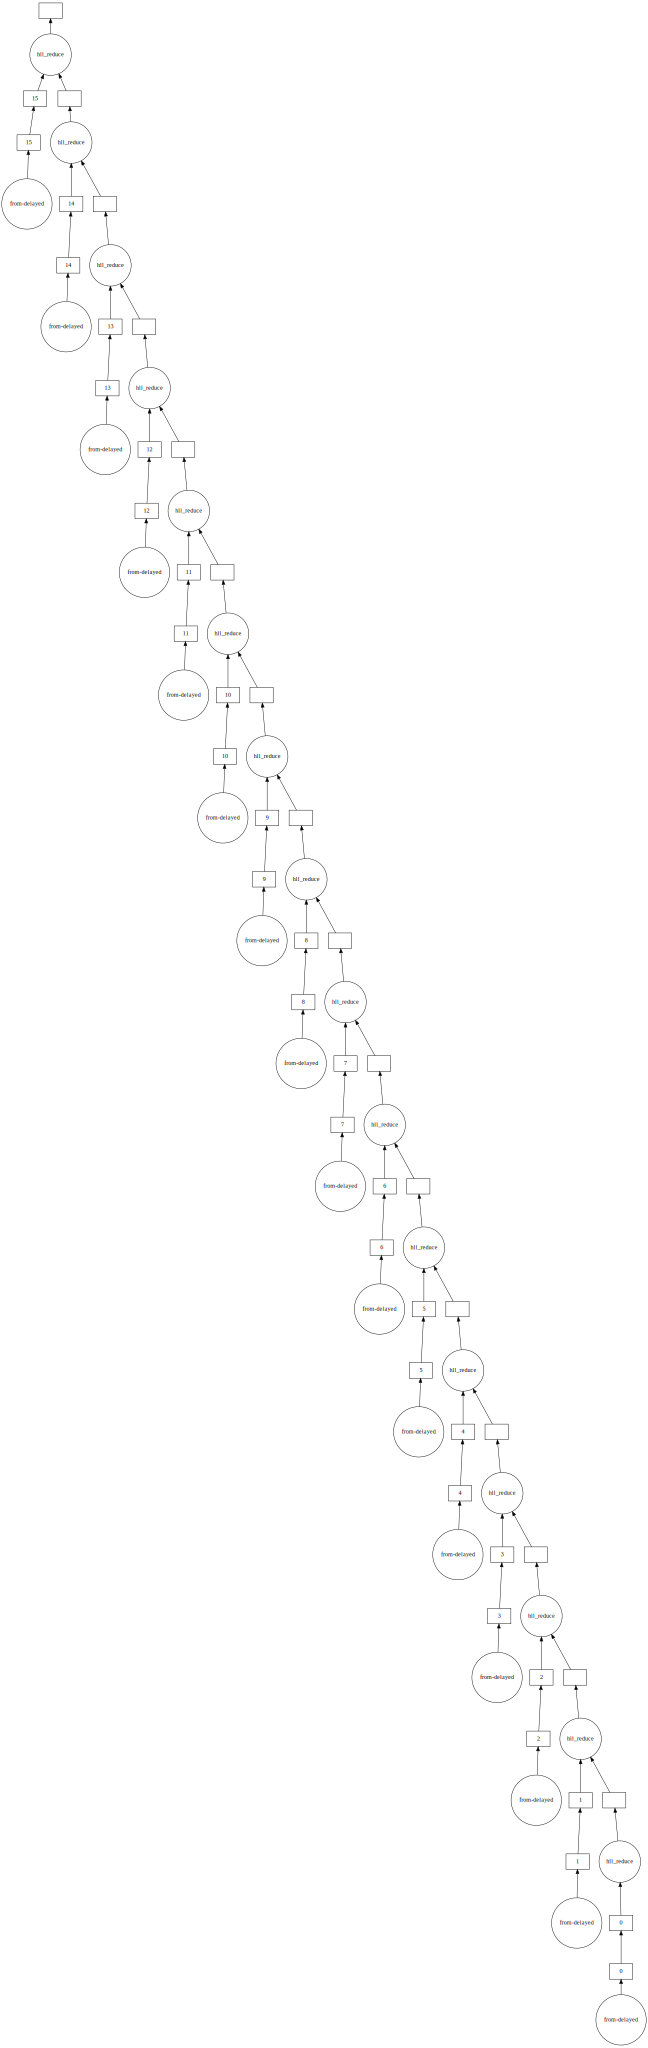

In [48]:
dask.visualize( *tasks, format='svg', filename='cascade-reduce-graph' )